# FP

## v2 - softmax 2, pandas, 
## next v3 - GAN , embeddings and visualization:  tensorboard and ...matplot

Start writing all my logic in jupyter notebook in order to run them from anaconda! <br>
** IMPORTANT ** <br>
the network cell should only be intialize once! otherwise the program start creating indexes for the variables!!!! 

tensorboard --logdir=.\my_graph	
tensorboard => http://localhost:6006 <br>
jupyter => http://localhost:8889

## index: 
<a id='index'/>

1. READ DATA 
    * Class 
    * files 
2. [Network](#model)
3. [execution](#exec) 
4. [display](#disp)


other: 
4. [Evaluate](#ev) 
5. [Test](#ts) 
6. [Other](#o)

[go back](#index)

In [1]:
import pandas as pd 
import tensorflow as tf 
import numpy as np 
import matplotlib.pyplot as plt
import itertools

import requests
import json
import sys
import os
import time
from types import *
from collections import Counter
from datetime import datetime

In [2]:
import utils_data as md

start = time.time()
start

1523452412.313251

In [3]:
datetime.now().strftime('%H:%M:%S')

'15:13:32'

In [4]:
# tensorboard --logdir=.\mygraph

# Network ops

In [5]:
def get_nns(): 
    #nns =  str(ninp)+'*'+str(h[0])+'*'+str(h[1])+'*'+str(nout)
    nns =  str(ninp)+'x' 
    for i in range(len(h)):
        nns = nns +str(h[i])+'x'
    return nns +str(nout)
#script hpar (s)
def get_hpar(ep=100, final="_"): return "slr_%.0E_NN%s_ep%s%s" % (lr, get_nns(),str(ep),final)
def logr(datep = '' , time='', it=1000, nn='', typ='TR', DS='', AC=0, num=0, AC3=0, AC10=0, desc='', startTime=''):
    if desc == '': print("Log not recorded"); return 
    LOG = "../../LOGT2.txt"
    f= open(LOG ,"a+") #w,a,
    if datep != '':   dats = datep
    else:             dats = datetime.now().strftime('%d.%m.%Y') 
    if time != '':    times = time
    else:             times = datetime.now().strftime('%H:%M:%S') 

    line =  datetime.now().strftime('%d.%m.%Y') + '\t' + times # time C1,C2
    #v1
    # line = line + '\t' + str(it) + '\t'+  get_nns() +  '\t' + str(lr) # IT NN LR TYP 
    #v2
    line = line + '\t' +  get_hpar(epochs, final=final) + '\t'+ '\t' 
    # values 
    line = line + '\t' + typ + '\t' + str(DS) # type + domain 
    line = line + '\t' + str(AC) + '\t' + str(num) + '\t' + str(AC3) + '\t' +  str(AC10) + '\t' + desc 
    line = line + '\t' + str(batch_size) + '\t' +  startTime + '\n' #new

    f.write(line);  f.close()
    print("___Log recorded")    
def restore_model(sess):   
    saver= tf.train.Saver() 
    print("Model restored from file: %s" % model_path)
    saver.restore(sess, model_path)


# Network  <a id="model"></a> 
[go back](#index)

In [6]:
# NETWORK-----------------------------------------------------
def fc(inp, nodes, kp, is_train):
    # h = tf.layers.dense( x, h[0], activation=tf.nn.relu,  name )
    h = tf.layers.dense( inp, nodes, use_bias=False, activation=None )
    if md.dType != "C0": h = tf.layers.batch_normalization(h, training=False)      # CLASS
    h = tf.nn.relu(h)
    if is_train: h = tf.nn.dropout(h, kp)
    return h
def build_network2(is_train=False):     # Simple NN - with batch normalization (high level)
    global top_k

    kp = 0.5
    inp = x
    # h0 = fc(x,  h[0], kp, is_train)
    # h1 = fc(h0, h[1], kp, is_train)    
    with tf.device('/gpu:1'):
        for i in range(len(h)): 
            hx = fc(inp,  h[i], kp, is_train); inp = hx 
        out = tf.layers.dense( hx, nout, use_bias=False, activation=None )
    
    #prediction=tf.reduce_max( y ,1)    # CLASS
    # prediction = out                 # REG

    # softmaxT = tf.nn.softmax(out)
    with tf.name_scope("accuracy"):
        softmaxT = tf.nn.top_k(tf.nn.softmax(out), top_k)                       # CLASS
        # values, indices  = tf.nn.top_k(tf.nn.softmax(out), top_k)             # CLASS
        # prediction_classes = table.lookup(tf.to_int64(indices))
        correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))       # CLASS
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))      # CLASS

        if md.dType == "C0":
            total_error = tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y))))        # REG
            unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y, out)))                # REG
            accuracy = tf.subtract(tf.to_float(1), tf.div(total_error, unexplained_error))   # REG

        tf.summary.scalar("accuracy", accuracy)

    return out, accuracy, softmaxT

def build_network3(is_train=False):
    tf.reset_default_graph()

    global prediction, accuracy, softmaxT, cost, summ, optimizer, saver, x, y, confusion

    print("build network")
    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32,     shape=[None, ninp], name="x")
        # y = tf.placeholder(tf.int16,     shape=[None, nout], name="y")
        y = tf.placeholder(tf.float32,     shape=[None, nout], name="y")
    
    prediction, accuracy, softmaxT = build_network2(is_train=is_train)
    # confusion = tf.confusion_matrix(labels=y, predictions=prediction, num_classes=nout)
    
    with tf.name_scope("xent"): #loss
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
        if md.dType == "C0": cost = tf.reduce_mean(tf.square(prediction-y) )               # REG
        tf.summary.scalar("xent", cost)
    
    with tf.name_scope("train"): #optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    summ = tf.summary.merge_all()
    saver= tf.train.Saver()

def build_network1( ):
    tf.reset_default_graph()
    global prediction, accuracy, softmaxT, cost, summ, optimizer, saver, x, y, confusion
    print("build network")

    with tf.device('/cpu:0'):
        x = tf.placeholder(tf.float32,     shape=[None, ninp], name="x")
        y = tf.placeholder(tf.float32,     shape=[None, nout], name="y")

    # Simple NN - 2layers - matmul 
    biases  = { 'b1': tf.Variable(tf.random_normal( [ h[0] ]),        name="Bias_1"),
                'b2': tf.Variable(tf.random_normal( [ h[1] ]),        name="Bias_2"),
                'out': tf.Variable(tf.random_normal( [nout] ),        name="Bias_out") }
    weights = { 'h1': tf.Variable(tf.random_normal([ninp,h[0]]),      name="Weights_1"),
                'h2': tf.Variable(tf.random_normal([h[0],h[1]]),      name="Weights_2"),
                'out': tf.Variable(tf.random_normal([h[1], nout]),    name="Weights_out")}
   
    with tf.device('/gpu:1'):
        # tf.reset_default_graph( )
        with tf.name_scope("fc_1"):
            layer_1 = tf.add(tf.matmul(x, weights['h1']), biases['b1'])
            layer_1 = tf.nn.relu(layer_1)
        # Hidden layer with RELU activation
        with tf.name_scope("fc_2"):
            layer_2 = tf.add(tf.matmul(layer_1, weights['h2']), biases['b2'])
            layer_2 = tf.nn.relu(layer_2)
        # Output layer with linear activation
        with tf.name_scope("fc_output"):
            out = tf.matmul(layer_2, weights['out']) + biases['out']
            prediction= out

    #softmaxT = tf.nn.softmax(out, )
    softmaxT = tf.nn.top_k(tf.nn.softmax(out), top_k)   

    with tf.name_scope("accuracy"):
        correct_prediction = tf.equal(tf.argmax(out, 1), tf.argmax(y, 1))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        tf.summary.scalar("accuracy", accuracy)
    
    #return out, accuracy, softmaxT, biases, weights
    
    with tf.name_scope("xent"): #loss
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=prediction, labels=y))
        if md.dType == "C0": cost = tf.reduce_mean(tf.square(prediction-y) )               # REG
        tf.summary.scalar("xent", cost)
    
    with tf.name_scope("train"): #optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=lr).minimize(cost)
    
    summ = tf.summary.merge_all()
    saver= tf.train.Saver()
    

# OPERATIONS

In [7]:
# OPERATIONS-----------------------------------------------------
def train(it = 100, disp=50, batch_size = 128, compt = False): 
    print("____TRAINING...")
    display_step =  disp 

    dataTest = {'label' : [] , 'data' :  [] }
    if compt: 
        md.get_columns(pp_excel = True )  # True! #md.dsc or dataset? 
        dataTest['data'] = md.dsc.iloc[:, 3:].as_matrix().tolist(); dataTest['label'] = md.dsc.iloc[:, 2].as_matrix().tolist()
     
    print("data read - lenTrain={}-{} & lenEv={}-{}, col = {}" 
            # .format(len(md.dataT["data"]), len(md.dataT["label"]),len(md.dataE["data"]),len(md.dataE["label"]) ))
            .format(len(md.dst.iloc[md.spn:, 3:]), len(md.dst.loc[md.spn:,'FP_P']),
            len( md.dst.iloc[:md.spn, 3:] ),len( md.dst.loc[:md.spn-1,'FP_P'] ), 
            len(dataTest['data'])
             ))
    
    total_batch  = int(len(md.dataT['label']) / batch_size)   
    startTime = datetime.now().strftime('%H:%M:%S')
    stored_ex = None 
    
    tf_config = tf.ConfigProto(allow_soft_placement=True) #,log_device_placement=True)
    tf_config.gpu_options.allow_growth = True
    
    with tf.Session(config=tf_config  ) as sess:
        sess.run(tf.global_variables_initializer())
        # restore_model(sess)  #Run if I want to retrain an existing model  
        writer = tf.summary.FileWriter(md.MODEL_DIR + "/tboard/", sess.graph ) # + get_hpar() )

        start = time.time()
        for i in range(it):  
            try:          
                if stored_ex : print("INT!"); break 
                
                for ii, (xtb,ytb) in enumerate(md.get_batches(batch_size) ):
                    # xtb, ytb = dc.next_batch(batch_size, dataT['data'], dataT['label'])
                    sess.run(optimizer, feed_dict={x: xtb, y: ytb})
                    
                    if ii % display_step ==0: #record_step == 0:
                        #[train_accuracy] = sess.run([accuracy], feed_dict={x: xtb, y: ytb })
                        # s = sess.run(summ, feed_dict={x: xtb, y: ytb })
                        [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: xtb, y: ytb }) 
                        writer.add_summary(s, i)
                        
                        elapsed_time = float(time.time() - start)
                        reviews_per_second = i / elapsed_time if elapsed_time > 0 else 0
                        rp_s = str(reviews_per_second)[0:5]
                        tr_ac = str(train_accuracy)[:5]  
                        print('Epoch: {} batch: {} / {} - %Speed(it/disp_step): {} - tr_ac {}' .format(i, ii, total_batch, rp_s, tr_ac ))
                        # writer.add_summary(s, i)
                test_accuracy = sess.run( accuracy, feed_dict={ x: md.dst.iloc[:md.spn, 3:],  y: md.dst.loc[:md.spn-1,'FP_P'].as_matrix().tolist()  })
                ev_ac = str(test_accuracy)[:5]  
                print("E Ac:", ev_ac)
                
                if compt: 
                    sess.run([optimizer], feed_dict={x: dataTest['data'], y: dataTest['label']})
                    tr_ac = str(sess.run(accuracy, feed_dict={x: dataTest['data'], y: dataTest['label']}))[:5] 
                    print("Cm Ac:", tr_ac)
                
                train_accuracy = sess.run( accuracy, feed_dict={ x: md.dst.iloc[md.spn:, 3:],  y: md.dst.loc[md.spn:,'FP_P'].as_matrix().tolist()   })
                tr_ac = str( train_accuracy )[:5] 
                print("T Ac:", tr_ac)
                train_accuracies.append(tr_ac)
                test_accuracies.append(ev_ac)

#                 test_accuracy = sess.run( accuracy, feed_dict={ x: md.dst.iloc[:md.spn, 3:],  y: md.dst.loc[:md.spn-1,'FP_P'].as_matrix().tolist()  })
#                 ev_ac = str(test_accuracy)[:5]  
#                 print("E Ac:", ev_ac)
#                 train_accuracy = sess.run( accuracy, feed_dict={ x: md.dst.iloc[md.spn:, 3:],  y: md.dst.loc[md.spn:,'FP_P'].as_matrix().tolist()   })
#                 tr_ac = str( train_accuracy )[:5] 
#                 print("T Ac:", tr_ac)

            except KeyboardInterrupt: 
                stored_ex = sys.exc_info()
        #end
        save_path = saver.save(sess, model_path)
        print("Model saved in file: %s" % save_path) 
    print("Optimization Finished!")

    logr( it=it, typ='TR', DS=md.DESC, AC=tr_ac,num=len(md.dst)-md.spn, AC3=0, AC10=0, desc=md.des(), startTime=startTime )
    logr( it=it, typ='EV', DS=md.DESC, AC=ev_ac,num=md.spn, AC3=0, AC10=0, desc=md.des() )
    dataTest = {'label' : [] , 'data' :  [] }

def train_opt( ): 
    print("____TRAINING OPT...")
    pass



def clean_traina():
    global train_accuracies, test_accuracies
    train_accuracies, test_accuracies = [], []
    
def vis_chart( ):
    fig, ax = plt.subplots()
    plt.plot(train_accuracies, label='Train', alpha=0.5)
    plt.plot(test_accuracies, label='Test', alpha=0.5)
    plt.title("Accuracy" + md.MODEL_DIR)
    plt.legend()
    # plt.savefig(md.MODEL_DIR + "/chart.png" )
    plt.savefig(md.MODEL_DIR + ".png" )
    # plt.show()
    return


   

# Vis and EV

In [8]:
def evaluate( ): 
    print("_____EVALUATION...")
    startTime = datetime.now().strftime('%H:%M:%S')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # test the model
        tr_ac = str(sess.run( accuracy, feed_dict={ x: md.dst.iloc[md.spn:, 3:],  y: md.dst.loc[md.spn:,'FP_P'].as_matrix().tolist()    }) )[:5]  
        ev_ac = str(sess.run( accuracy, feed_dict={ x: md.dst.iloc[:md.spn, 3:],  y: md.dst.loc[:md.spn-1,'FP_P'].as_matrix().tolist()  }))[:5] 
        print("Training   Accuracy:", tr_ac )
        print("Evaluation Accuracy:", ev_ac )
        # xtp1.append(dataTest['data'][i]);    ytp1.append(dataTest['label'][i])
        predv, sf = sess.run([prediction, softmaxT], feed_dict={x: md.dst.iloc[:md.spn, 3:]  }) # , y: md.dataE['label'] 
        # maxa = sess.run([prediction], feed_dict={y: predv })
        
    print("Preview the first predictions:")
    for i in range(20):
        print("RealVal: {}  - PP value: {}".format( md.dc( md.dst.loc[:md.spn-1,'FP_P'][i])   , 
                                                    md.dc( predv.tolist()[i], np.max(predv[i]))  ))
    gt3, gtM = md.check_perf_CN(sf, md.dst.loc[:md.spn-1,'FP_P'], False)
    logr(  it=epochs, typ='EV', AC=ev_ac,DS=md.DESC, num=md.spn, AC3=gt3, AC10=gtM, desc=md.des(), startTime=startTime )
    
    calc_confusion_m( sf, md.dst.loc[:md.spn-1,'FP_P'], "EV")

    # return predv.tolist()
    return sf

def tests(url_test = 'url', p_col=False):  
    print("_____TESTS...")    
    
    # Load test data 
    dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
    if p_col:                   # test columns 
        md.get_columns( )  #md.dsc
        dataTest['data'] = md.dsc.iloc[:, 3:].as_matrix().tolist(); dataTest['label'] = md.dsc.iloc[:, 2].as_matrix().tolist()
    elif p_col == False:        # test dataset 
        # logic migrated to get_tests -- 04.02
        # if url_test != 'url':   # test  file 
        #     json_data = url_test + "data_jsonX.txt"
        #     tmpLab = pd.read_csv(url_test + "datalX.csv", sep=',', usecols=[0,1])    
        #     tmpLab = tmpLab.loc[:,'fp']
        #     DESC   = "FREXP1_X"
        # else:                   # get data test JSON = url
        #     json_str, tmpLab = md.get_data_test(md.DESC)
        #     json_data = json.loads(json_str)
        #     DESC =  'matnrList...'
        # force = False

        md.get_tests(url_test ) #dsp
        dataTest['data']  = md.dsp.iloc[:, 3:].as_matrix().tolist(); dataTest['label'] = md.dsp.iloc[:, 2].as_matrix().tolist()     
    # Predict data 
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # predv = sess.run( prediction, feed_dict={x: dataTest['data']}) 
        ts_acn = '0'
        ts_acn, predv, sf = sess.run( [accuracy, prediction, softmaxT], feed_dict={x: dataTest['data'], y: dataTest['label']}) 
        ts_ac = str(ts_acn) 
        print("test ac = {}".format(ts_ac))
    
    # print(dataTest['label']);     print(sf)
    range_ts = len(predv) if len(predv)<20 else 20
    for i in range( range_ts ):
        # print("RealVal: {}  - PP value: {}".format( md.dc( dataTest['label'][i]), md.dc( predv.tolist()[i], np.max(predv[i]))  ))  
        print("{} RealVal: {} - {} - PP: {} PR: {}".format( i, md.dc( dataTest['label'][i]), sf[1][i][0],  sf[1][i], sf[0][i]  ))

    # return
    gt3, gtM = md.check_perf_CN(sf, dataTest["label"], False)
    logr( it=0, typ='TS', DS=md.DESC, AC=ts_acn ,num=len(dataTest["label"]),  AC3=gt3, AC10=gtM, desc=md.des() )  

#     calc_confusion_m( sf, md.dsp["FP_P"], "TS" )

    # outfile = md.LOGDAT + 'export2' 
    # np.savetxt(outfile + '.csv', sf[1], delimiter=',')
    # np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')
    dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
    return sf

def tests_exec(url_test = 'url', ret_str=True):  
    dataTest = {'label' : [] , 'data' :  [] }; pred_val = []
    # md.get_tests(url_test) #dsp
    tmpLab = [1] # dummy 
    json_str = url_test
    # print(json_str)
    if json_str[0]=="'": 
        json_str = json_str[1:]
        if json_str[len(json_str)-1]=="'": json_str = json_str[:len(json_str)-1]
        json_str = json_str.replace("'", '"')
    json_str = "[" + json_str + "]" 
    # json_str =   '''{ "m":"1", "100023" : 1 }  ''';  json_str = "[" + json_str + "]" 
    # print(json_str)
    json_data = json.loads(json_str)
    # print(json_data)
    md.dsp = md.feed_data(json_data ,pand=True, d_st=True, p_all = True)       #d_st = display status
    ds = md.dsp.iloc[0]
    if len(ds.iloc[ds.nonzero()]) == 1: return "error: comp 0"
    md.dsp["FP"] = tmpLab; 
    md.dsp.insert(2, 'FP_P', md.dsp['FP'].map(lambda x: md.cc( x )))
    dataTest['data']  = md.dsp.iloc[:, 3:].as_matrix().tolist();   # No FP
    dataTest['label'] = md.dsp.iloc[:, 2].as_matrix().tolist()     # dummy 
     
    # md.print_form2(dsp.iloc[0]);     # print(dsp.iloc[0])
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        restore_model(sess)
        # predv = sess.run( prediction, feed_dict={x: dataTest['data']}) 
        predv, sf = sess.run( [ prediction, softmaxT], feed_dict={x: dataTest['data']}) #, y: dataTest['label']}) 

    for i in range( 1 ):
        # print("RealVal: {}  - PP value: {}".format( md.dc( dataTest['label'][i]), md.dc( predv.tolist()[i], np.max(predv[i]))  ))  
        print("{} RealVal: {} - {} - PP: {} PR: {}".format( i, md.dc(dataTest['label'][i]), sf[1][i][0],  sf[1][i], sf[0][i]  ))
    
    logr( it=0, typ='AP', DS=md.DESC, AC=sf[1][0] ,num=sf[0][0],  AC3=0, AC10="real?", desc=str(md.dsp.iloc[0,0] ) )  
    # logr( it=0, typ='TS', DS=md.DESC, AC=ts_acn ,num=len(dataTest["label"]),  AC3=gt3, AC10=gtM, desc=md.des() )  

    # if ret_str: return "PP: {} PR: {}".format(sf[1][0], sf[0][0] )
    if ret_str: return "PP: {} PR: {}".format(sf[1][0], sf[0][0] )
    else: return md.get_json_format(md.dType, sf[1][0], sf[0][0] )

In [9]:
def vis_confusion_m(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues, 
                          tid="t"):
    plt.figure()
    if md.dType == "C1": 
        fig = plt.gcf()
        fig.set_size_inches(32, 32)
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#     plt.savefig(md.LOGDAT + md.dType + "_" + tid + "conf_mat.png" )
    plt.show()
    # plt.clf()
    # plt.cla()  # for multiple subplots


iccm = 0 
def calc_confusion_m( sf, dst, tid="t"):
    global iccm 
    confusion = tf.confusion_matrix(    labels=md.get_conv_list(  dst ), 
                                        predictions=[ sf[1][x][0]  for x in range( len(sf[1]) )   ], 
                                        num_classes=nout)
    with tf.Session() as sess:
        conf = sess.run(confusion)
   
    np.savetxt(md.LOGDAT + "cm" + tid +".csv", conf, delimiter=",")
    
    if md.dType == "C1N": 
        print(conf)
    else: 
        class_names = [str(i) for i in range(md.nout)]
        vis_confusion_m( conf, classes=class_names, normalize=False,
                            title='Confusion matrix, without normalization',
                            cmap=plt.cm.cool, tid=tid)


# Network1 - TES

In [10]:
md.DESC      = "FRALL1" # "FREXP"  FRFLO FRALL1
md.spn       = 10000  
md.dType     = "C4" #C1, C2, C4, C0

#---------------------------------------------------------------
# DATA READ 
#---------------------------------------------------------------
ALL_DS     = md.LOGDAT + md.DESC + md.DSC 
md.mainRead2(ALL_DS, 1, 2, all = True, shuffle = True  ) 
# md.mainRead2(ALL_DS, 1, 2, all = False ) # For testing I am forced to used JSON - column names and order may be different! 
md.normalize()


data read - 45822 - time:34.46571731567383


In [22]:
epochs       = 100 #100
lr           = 0.001 #0.0001
h            = [10000 , 5000]   #[40 , 10]   [200, 100, 40] [100,100]
ninp, nout   = 10, 10
batch_size   = 128
final        = "j" #FF or _

ninp, nout, top_k = md.getnn()
# print(len(md.dst))
md.MODEL_DIR = md.LOGDIR + md.DESC + '/'   + get_hpar(epochs, final=final) +"/" 
model_path = md.MODEL_DIR + "model.ckpt"

In [23]:
force = True        
url_test = md.LOGDAT + "FREXP1/" ; # url_test = "url"
md.get_tests(url_test=url_test, force=force, pp_excel=True)
# md.get_columns(force, True)

In [24]:
build_network3()
print(model_path)
print( get_nns() )

md.MODEL_DIR

build network
../../dmodels/FRALL1/slr_1E-03_NN2385x10000x5000x4_ep100j/model.ckpt
2385x10000x5000x4


'../../dmodels/FRALL1/slr_1E-03_NN2385x10000x5000x4_ep100j/'

# EXECUTIONS TR <a id="exec"/>
[go back](#index)

In [14]:
def fprint(ds, ds_pred):
    pass

In [25]:
clean_traina()

In [26]:
epochs       = 50 #100
disp         = 50
batch_size   = 128
train(epochs, disp, batch_size, True)

____TRAINING...
data read - lenTrain=35822-35822 & lenEv=10000-10000, col = 2385
35712
Epoch: 0 batch: 0 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.609
Epoch: 0 batch: 50 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.890
Epoch: 0 batch: 100 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.867
Epoch: 0 batch: 150 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.875
Epoch: 0 batch: 200 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.882
Epoch: 0 batch: 250 / 0 - %Speed(it/disp_step): 0.0 - tr_ac 0.859
E Ac: 0.834
Cm Ac: 0.635
T Ac: 0.839
35712
Epoch: 1 batch: 0 / 0 - %Speed(it/disp_step): 0.032 - tr_ac 0.882
Epoch: 1 batch: 50 / 0 - %Speed(it/disp_step): 0.027 - tr_ac 0.960
Epoch: 1 batch: 100 / 0 - %Speed(it/disp_step): 0.024 - tr_ac 0.921
Epoch: 1 batch: 150 / 0 - %Speed(it/disp_step): 0.021 - tr_ac 0.937
Epoch: 1 batch: 200 / 0 - %Speed(it/disp_step): 0.019 - tr_ac 0.906
Epoch: 1 batch: 250 / 0 - %Speed(it/disp_step): 0.018 - tr_ac 0.914
E Ac: 0.843
Cm Ac: 0.839
T Ac: 0.830
35712
Epoch: 2 batch: 0 / 0 - %Spee

Epoch: 18 batch: 50 / 0 - %Speed(it/disp_step): 0.032 - tr_ac 0.992
Epoch: 18 batch: 100 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.968
Epoch: 18 batch: 150 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.984
Epoch: 18 batch: 200 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.976
Epoch: 18 batch: 250 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.976
E Ac: 0.884
Cm Ac: 0.990
T Ac: 0.973
35712
Epoch: 19 batch: 0 / 0 - %Speed(it/disp_step): 0.032 - tr_ac 0.984
Epoch: 19 batch: 50 / 0 - %Speed(it/disp_step): 0.032 - tr_ac 0.984
Epoch: 19 batch: 100 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.992
Epoch: 19 batch: 150 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.992
Epoch: 19 batch: 200 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.976
Epoch: 19 batch: 250 / 0 - %Speed(it/disp_step): 0.031 - tr_ac 0.968
E Ac: 0.878
Cm Ac: 0.991
T Ac: 0.970
35712
Epoch: 20 batch: 0 / 0 - %Speed(it/disp_step): 0.032 - tr_ac 0.992
Epoch: 20 batch: 50 / 0 - %Speed(it/disp_step): 0.032 - tr_ac 0.976
Epoch: 20 batch: 100 / 0

Epoch: 36 batch: 100 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 1.0
Epoch: 36 batch: 150 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.992
Epoch: 36 batch: 200 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 1.0
Epoch: 36 batch: 250 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.976
E Ac: 0.855
Cm Ac: 0.992
T Ac: 0.961
35712
Epoch: 37 batch: 0 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.984
Epoch: 37 batch: 50 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.976
Epoch: 37 batch: 100 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 1.0
Epoch: 37 batch: 150 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.984
Epoch: 37 batch: 200 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.992
Epoch: 37 batch: 250 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.992
E Ac: 0.873
Cm Ac: 0.993
T Ac: 0.975
35712
Epoch: 38 batch: 0 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.992
Epoch: 38 batch: 50 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 0.992
Epoch: 38 batch: 100 / 0 - %Speed(it/disp_step): 0.030 - tr_ac 1.0
Epoch: 38 batch: 150 / 0 - %Spe

# EXECUTIONS EV

_____EVALUATION...
Model restored from file: ../../dmodels/FRALL1/slr_1E-03_NN2385x100x50x4_ep100j/model.ckpt
INFO:tensorflow:Restoring parameters from ../../dmodels/FRALL1/slr_1E-03_NN2385x100x50x4_ep100j/model.ckpt
Training   Accuracy: 0.964
Evaluation Accuracy: 0.882
Preview the first predictions:
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 3  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 2  - PP value: 2
RealVal: 1  - PP value: 2
RealVal: 3  - PP value: 3
RealVal: 2  - PP value: 2
RealVal: 3  - PP value: 3
denormalization all Evaluation : 10000 = 10000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
Total: 10000 GT3: 1172  GTM: 1172
___Log recorded
Confusion matrix, without normaliz

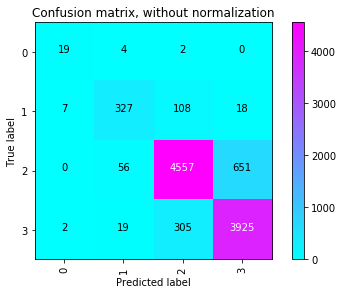

In [17]:
evd = evaluate( )

In [25]:
# fprint(ran, data, pred)

# Ex Test

In [19]:
# md.dsp
sft = tests(url_test, p_col=False  )
# vis_chart( )

_____TESTS...
Model restored from file: ../../dmodels/FRALL1/slr_1E-03_NN2385x100x50x4_ep100j/model.ckpt
INFO:tensorflow:Restoring parameters from ../../dmodels/FRALL1/slr_1E-03_NN2385x100x50x4_ep100j/model.ckpt
test ac = 0.9278253
0 RealVal: 2 - 2 - PP: [2 3 0] PR: [9.9999940e-01 6.4999676e-07 7.4610242e-11]
1 RealVal: 2 - 2 - PP: [2 3 1] PR: [1.0000000e+00 6.7715001e-13 1.0103578e-13]
2 RealVal: 2 - 2 - PP: [2 1 3] PR: [9.996107e-01 3.703199e-04 1.714901e-05]
3 RealVal: 2 - 2 - PP: [2 3 0] PR: [9.9998927e-01 1.0581019e-05 9.2692652e-08]
4 RealVal: 3 - 3 - PP: [3 2 0] PR: [9.9296182e-01 7.0256856e-03 1.2473733e-05]
5 RealVal: 2 - 2 - PP: [2 3 0] PR: [9.9734962e-01 2.6479012e-03 2.4261549e-06]
6 RealVal: 2 - 2 - PP: [2 3 0] PR: [9.946163e-01 5.380081e-03 3.504085e-06]
7 RealVal: 3 - 3 - PP: [3 2 0] PR: [9.9986875e-01 1.3125213e-04 8.9523757e-09]
8 RealVal: 2 - 2 - PP: [2 3 1] PR: [9.9851519e-01 1.4499767e-03 2.2334087e-05]
9 RealVal: 2 - 2 - PP: [2 3 0] PR: [9.8585606e-01 1.4102685e-02

In [19]:
# print(dataTest['data'])
# sft[1][0][0]
# [ sft[1][x][0]  for x in range( len(sft[1]) )   ]

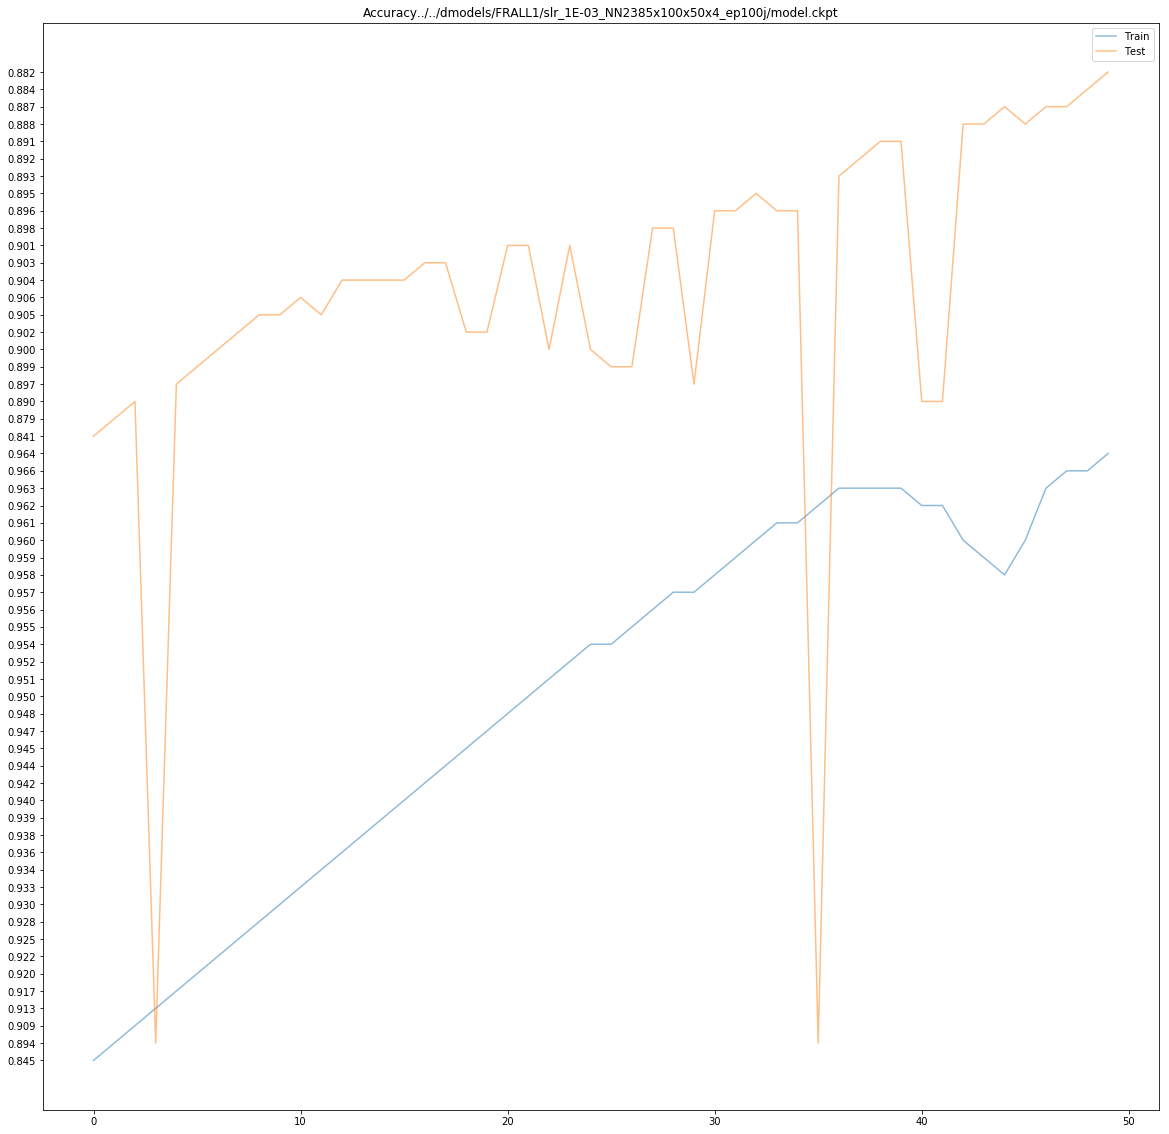

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)
plt.plot(train_accuracies, label='Train', alpha=0.5)
plt.plot(test_accuracies, label='Test', alpha=0.5)
plt.title("Accuracy"+model_path)
plt.legend()
# plt.show()
# plt.savefig(md.MODEL_DIR + "chart.png" )


# 1RUN 

In [36]:
import mRun as mr
execc = [
            { 'dt':'C2',  "e":100, "lr":0.001, "h":[100 , 100], "spn": 5000, "pe": [], "pt": []  },
            { 'dt':'C4',  "e":100, "lr":0.001, "h":[100 , 100], "spn": 5000, "pe": [], "pt": []  },
            { 'dt':'C1',  "e":100, "lr":0.001, "h":[100 , 100], "spn": 5000, "pe": [], "pt": []  },
        ]

final = "_" ;  md.DESC = "FRAFLO";  # FRFLO   FRALL1
ALL_DS = md.LOGDAT + md.DESC + md.DSC 

In [ ]:
# DATA READ 
# md.mainRead2(ALL_DS, 1, 2 ) # , all = True, shuffle = True  ) 
md.mainRead2(path=ALL_DS, part=1, batch_size=2 ) # For testing I am forced to used JSON - column names and order may be different! 
url_test = md.LOGDAT + "FREXP1/" ; # url_test = "url"
force = False; excel = True  # dataFile = "frall2_json.txt"; labelFile = "datal.csv"     
md.get_tests(url_test, force, excel )

In [ ]:
for ex in execc:
    md.spn = ex["spn"]; md.dType = ex["dt"]; mr.epochs = ex["e"]

    md.normalize()
    mr.ninp, mr.nout, mr.top_k = md.getnn()
    md.MODEL_DIR = md.LOGDIR + md.DESC + '/'   + mr.get_hpar(mr.epochs, final=final) +"/" 
    mr.model_path = md.MODEL_DIR + "model.ckpt" 
    mr.build_network3()
    print(mr.model_path)    

    # mr.evaluate( )

    ex["pt"] = mr.tests(url_test, p_col=False  )

In [ ]:
print("0<60_1>60__0<23_1<60_2<93_3>93  ")
for i in range(20):
    print("m:{0:15} - R-{4:5}   ||    P1-{1:2}         P2-{2:2}        P3-{3}" 
    .format(md.dsp.iloc[i,0], execc[0]["pt"][1][i][0], execc[1]["pt"][1][i][0],  execc[2]["pt"][1][i], md.dsp.iloc[i,1], ))    


# Embedding by FAM
get data / get FAM <br>
if am > 0 => 1; lookup tab.  => visualization embeddings in script. 


In [66]:
#logic... 




# WRITE EXCEL

In [27]:
# import xlsxwriter
# outfile = '../../_zfp/data/export.xlsx' 

# workbook   = xlsxwriter.Workbook(outfile)
# worksheet1 = workbook.add_worksheet()
# worksheet1.write('A1', 'M')
# worksheet1.write(0, 0, 'Hello')  
# for i in range(len(sf[0])):
#     worksheet1.write(0, i , sf[0][i])  
#     worksheet1.write(1, i , sf[1][i]) 

In [28]:
# import csv
# outfile = '../../_zfp/data/export.csv' 
# f2= open(outfile,"a+")
# output_writer = csv.writer(f2, delimiter="\t")
# output_writer.writerows(sf)
# f2.close()

In [29]:
# outfile = '../../_zfp/data/export2' 
# np.savetxt(outfile + '.csv', sf[1], delimiter=',')
# np.savetxt(outfile + 'PRO.csv', sf[0], delimiter=',')

# Display visualizations <a id="disp"/>
[go back](#index)

In [30]:
# path = outfile = '../../_zfp/data/FRFLO/datasc.csv' 
# dst  =  pd.read_csv( tf.gfile.Open(path), sep=None, skipinitialspace=True,  engine="python")
Y  = dst.loc[:,'FP'].as_matrix().tolist()
X  = dst.loc[:, 'M'].as_matrix().tolist()

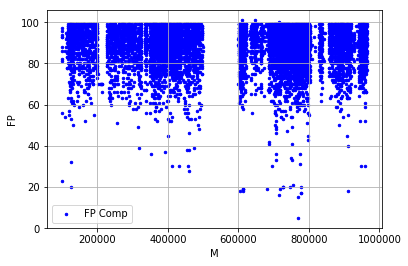

In [31]:
# 2 - Create plot. 
a = 1
if a == 0: 
    plt.hist(Y)
else: 
    plt.xlabel('M')
    plt.ylabel('FP')
    plt.grid(True)
    N = 2 #50
    colors = np.random.rand(N)
    area = 1 #np.pi * (15 * np.random.rand(N))**2  # 0 to 15 point radii

    #plt.plot(X, Y, color='blue', marker='o', label='FP Comp')
    #plt.plot(X, Y, 'bo', label='FP Comp')
    plt.scatter(X,Y, s=6, c='b', marker='o', cmap=None, norm=None, vmin=60, vmax=101, alpha=None,  label='FP Comp')
    # plt.plot(X, Y,  s=area, c=colors, alpha=0.5) #'bo', label='FP Comp',
    plt.legend()

# 3 - Display plot. 

plt.show()